In [605]:
import numpy as np
import pandas as pd
from my_gmd import *
from scipy.stats import norm
from scipy.optimize import fixed_point
import matplotlib.pyplot as plt
from warnings import warn
from typing import Optional
plt.style.use('bmh')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basic model and fake jumpy asset price

## first simulation and explanations

In [42]:
basic_simul = GMD_simluation(tmax=200, 
                        sigma_price=0.5, 
                        proba_jump=0.005, 
                        alpha=0.5, 
                        eta=0.5, 
                        sigma_noise=0.05,
                        V0=100, 
                        multiplier=100)

In [43]:
print(basic_simul)

GMD simulation with following params: 
- 200 iterations
- price with jump probability 0.005 and amplitude std 0.5 (current path has 3 jumps)
- proportion informed traders is 0.5
- noise std of informed traders is 0.05
- probability of random trade by uninformed traders is 0.5
- V(t=0)=100, multiplier is 100 so prob density len is 400
       Not run yet       


In [48]:
basic_simul.run_simulation()

100%|██████████| 200/200 [01:08<00:00,  2.92it/s]

Simulation finsihed


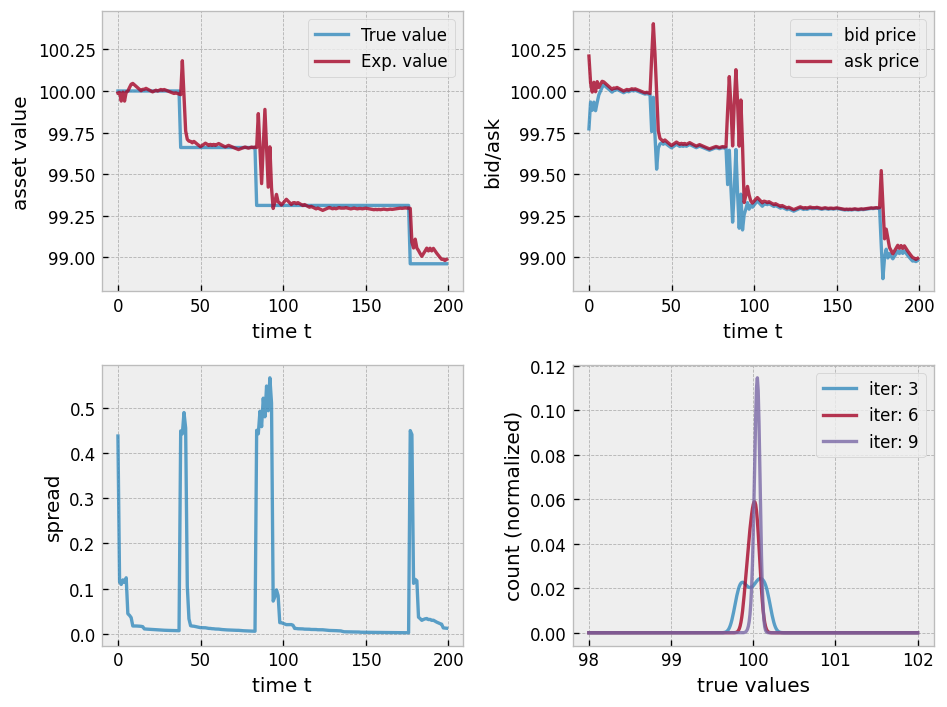

In [58]:
basic_simul.show_result(figsize=(8,6), dpi=120)

Observations:

- upper left corner:
     - we see the jumpy true value process and the expected value that follows it, modulo some uncertainty
     - uncertainty is higher right after jumps (not before)
- upper right corner: 
    - bid and ask prices follow it as well and seam to be closer after some time : the market maker digests the information it receives and cannot instanlty assess where the true value is
- lower left corner:
    - spread is high at the beggining as the market maker does not know the true value (only the most probable value (due to its initial prior distribution on V centered at V0=100))
    - the spreads lowers after as the price information is digested by the market maker (given no jump occurs)
    - the spread shoots up when a jump occur because suddenly, the MM knows a new information came in (knows a jump occured) but does not know if its positive/negative jump, nor its amplitude.
        - therefore its quotes are further appart: this is where informed traders have an edge: 
- lower right corner:
    - we can see the true value distribution of the MM changing shape as the MM updates it. 
    - starts a gaussian but quickly becomes more peaked around the true value due to information contained in informed trades (the MM only knows the proportions of the informed and uninformed traders in the crowd, so its updates are probabilistic)
        

## Information asymmetry

This explores what happens when there is more informed traders (still noisy or perfectly informed) than uninformed ones and vice versa

In [59]:
info_asym = GMD_simluation(tmax=300, 
                        sigma_price=0.5, 
                        proba_jump=0.005, 
                        alpha=0.9, 
                        eta=0.5, 
                        sigma_noise=0.05,
                        V0=100, 
                        multiplier=100)

In [61]:
print(info_asym)

GMD simulation with following params: 
- 300 iterations
- price with jump probability 0.005 and amplitude std 0.5 (current path has 1 jumps)
- proportion informed traders is 0.9
- noise std of informed traders is 0.05
- probability of random trade by uninformed traders is 0.5
- V(t=0)=100, multiplier is 100 so prob density len is 400
       Not run yet       


In [62]:
info_asym.run_simulation()

100%|██████████| 300/300 [01:41<00:00,  2.95it/s]

Simulation finsihed


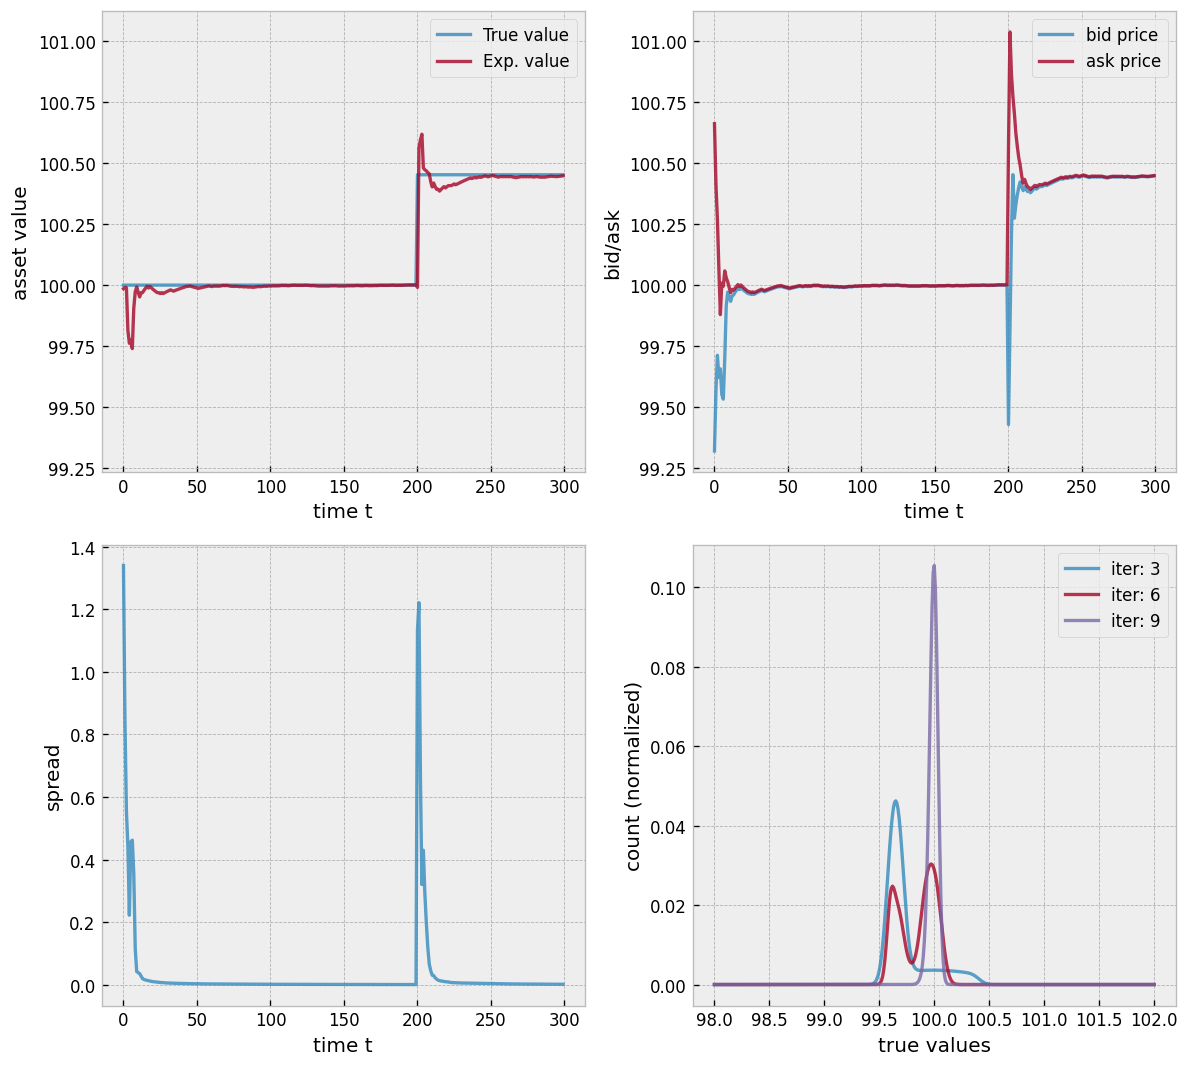

In [63]:
info_asym.show_result(dpi=120)

Now change the proportion of informed traders to 0.1 and re run with same price dynamics

In [64]:
info_asym.alpha = 0.1

In [65]:
## rerun
info_asym.run_simulation()

100%|██████████| 300/300 [01:41<00:00,  2.96it/s]

Simulation finsihed


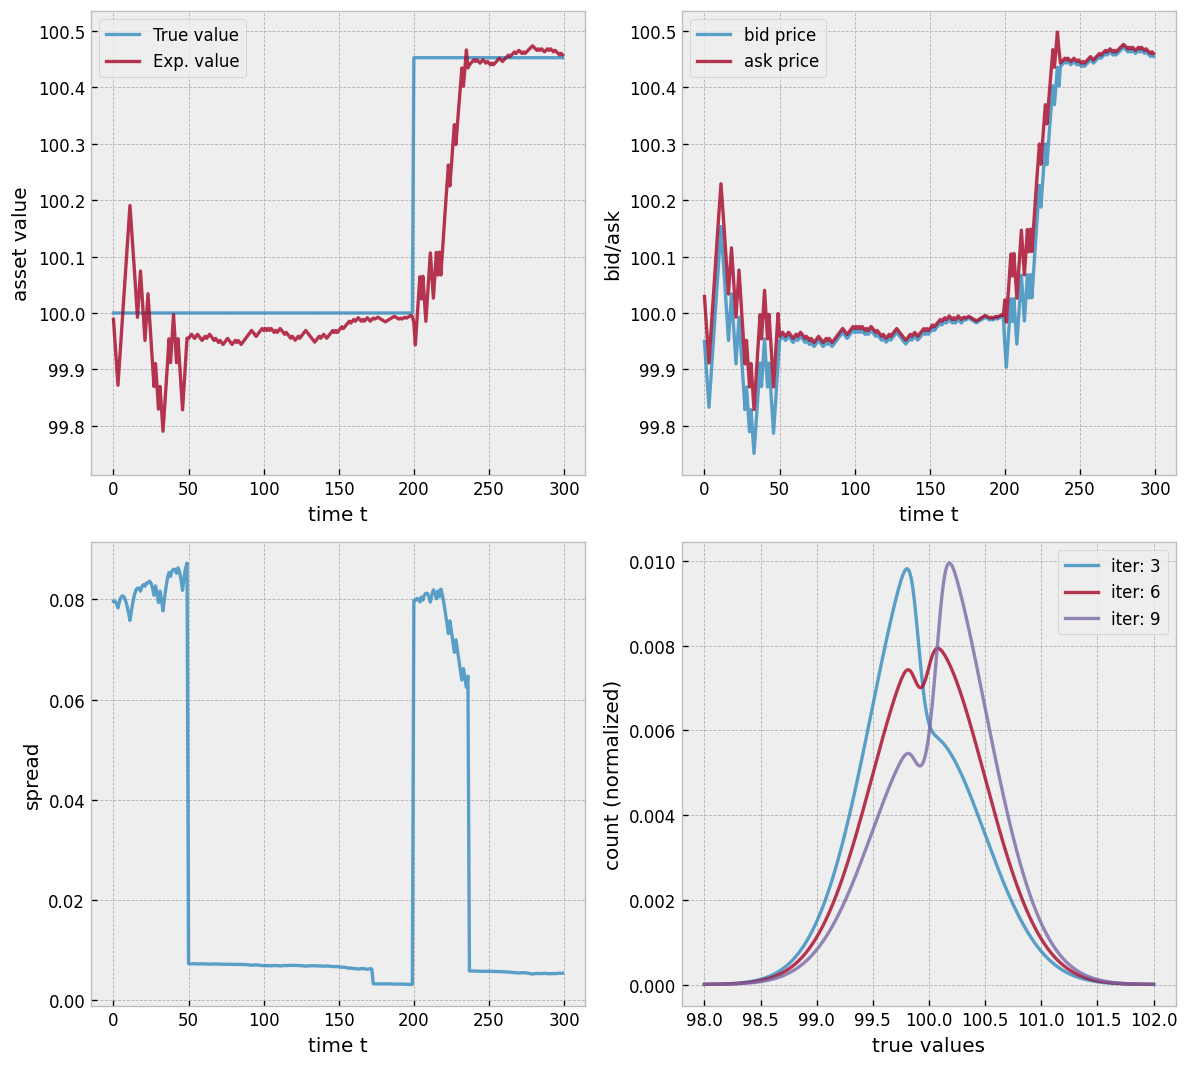

In [66]:
info_asym.show_result(dpi=120)

Observations:

These 2 simulations mostly differ in the time needed to process a jump.

- the exp value, bid and ask prices of the simulation with almost only informed traders resolve very quickly towards sustainable values (low spread, and expected value close to true value)
- on the opposite, uninformed traders carry less information than informed ones for the market maker:
    - therefore the expected value is more volatile and has a hard time finding the true value in the latter case
    - the bids and asks prices are further appart for a longer time until the price converged to the true value. Once it converged, the market maker quotes a tight spread again


- This is information asymmetry: right after a jump information is heterogeneous. asymmetry gets resolved quickier the more informed traders there are

Now if we increase the proba of jumps: the the price could almost never reflect the true value due to rate of coming information (jumps) higher than processing rate of the MM (due to too much uninformed traders

In [71]:
uninf_traders_high_pjump = GMD_simluation(tmax=300, 
                                            sigma_price=0.5, 
                                            proba_jump=0.05, 
                                            alpha=0.1, 
                                            eta=0.5, 
                                            sigma_noise=0.05,
                                            V0=100, 
                                            multiplier=100)

In [73]:
print(uninf_traders_high_pjump)

GMD simulation with following params: 
- 300 iterations
- price with jump probability 0.05 and amplitude std 0.5 (current path has 17 jumps)
- proportion informed traders is 0.1
- noise std of informed traders is 0.05
- probability of random trade by uninformed traders is 0.5
- V(t=0)=100, multiplier is 100 so prob density len is 400
       Not run yet       


In [74]:
uninf_traders_high_pjump.run_simulation()

100%|██████████| 300/300 [01:48<00:00,  2.77it/s]

Simulation finsihed


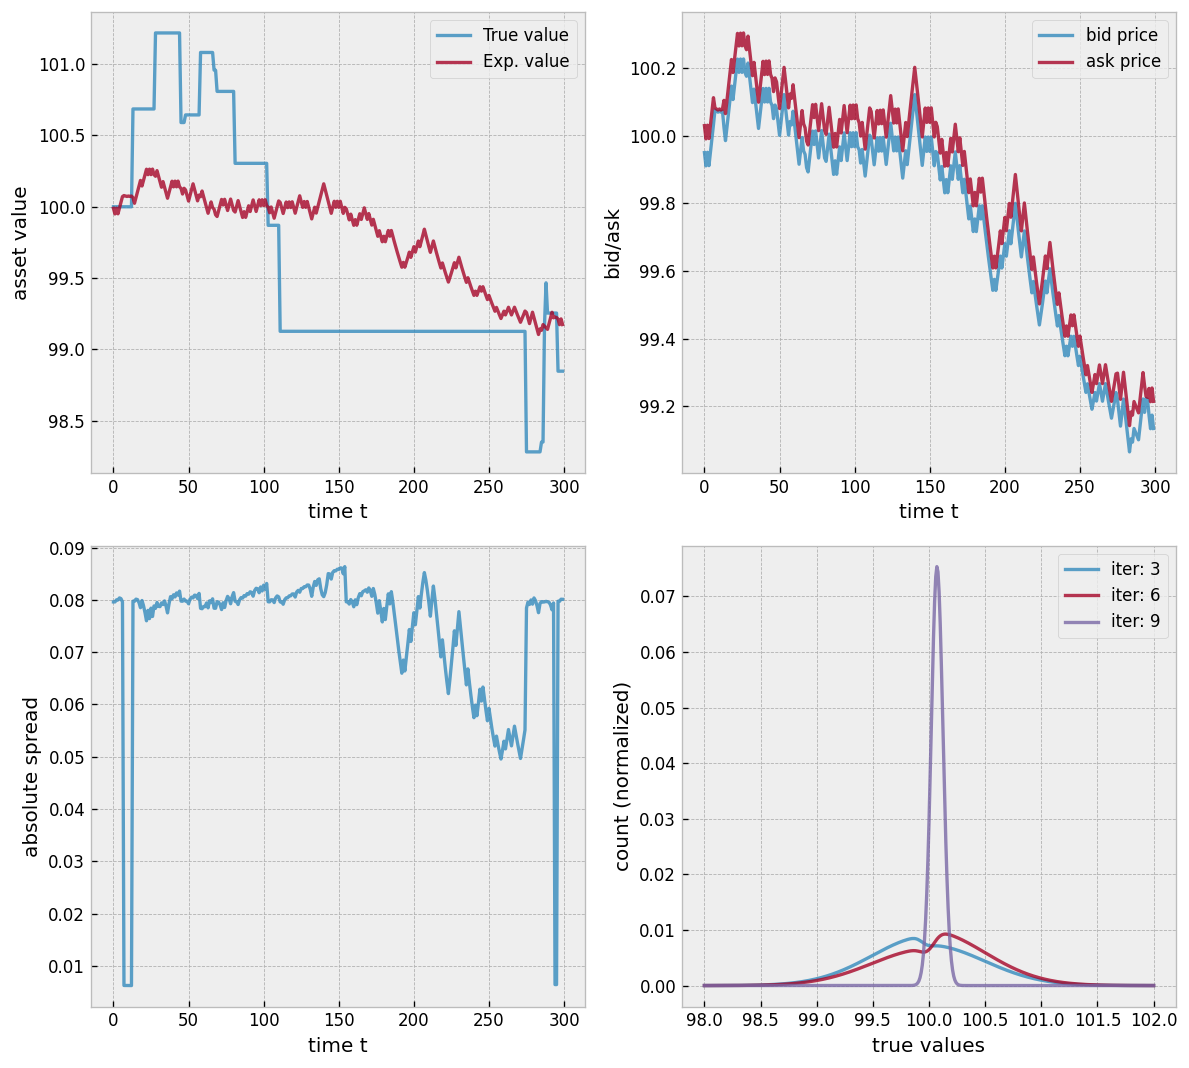

In [77]:
uninf_traders_high_pjump.show_result(dpi=120, same_y_axis_above=False)

Observations:

- with more jumps occuring, the expected value and true value are off
- the (absolute) spread remains quite high throughout the simulation

Analysis of resolving info asymmetry after jump

In [167]:
low_vol = Spread_after_jump_analysis(
                            number_of_simulations=30,
                            tmax=300, 
                            sigma_price=0.5, 
                            proba_jump=0.008, 
                            alpha=0.5, 
                            eta=0.5, 
                            sigma_noise=0.05,
                            V0=100, 
                            multiplier=20)

In [168]:
higher_vol = Spread_after_jump_analysis(
                            number_of_simulations=30,
                            tmax=300, 
                            sigma_price=1, 
                            proba_jump=0.008, 
                            alpha=0.5, 
                            eta=0.5, 
                            sigma_noise=0.05,
                            V0=100, 
                            multiplier=20)

In [169]:
jumps_spreads_low_vol = low_vol.run_simulation()

100%|██████████| 30/30 [07:42<00:00, 15.40s/it]


In [170]:
jumps_spreads_high_vol = higher_vol.run_simulation()

100%|██████████| 30/30 [17:42<00:00, 35.40s/it]


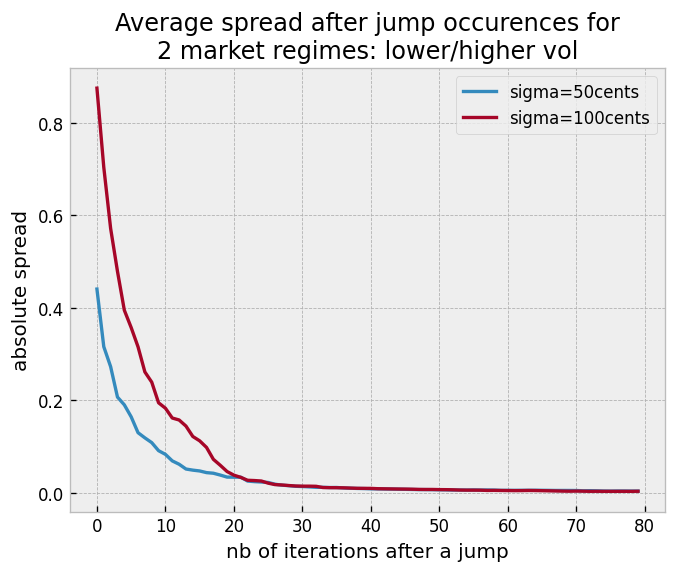

In [172]:
plt.figure(dpi=120)
plt.plot(pd.DataFrame(jumps_spreads_low_vol).T.mean(1).head(80), label="sigma=50cents")
plt.plot(pd.DataFrame(jumps_spreads_high_vol).T.mean(1).head(80), label="sigma=100cents")
plt.xlabel("nb of iterations after a jump")
plt.ylabel("absolute spread")
plt.legend()
plt.title("Average spread after jump occurences for\n2 market regimes: lower/higher vol")
plt.show()


Observations:


- As stated in the Das paper, the absolute spread decays quite quickly after a jump, and does not depend much on std of the jump. After 30 iterations, the spread is back at low levels

In [606]:
not_informed = Spread_after_jump_analysis(
                            number_of_simulations=30,
                            tmax=300, 
                            sigma_price=0.5, 
                            proba_jump=0.008, 
                            alpha=0.2, 
                            eta=0.5, 
                            sigma_noise=0.05,
                            V0=100, 
                            multiplier=20)

In [608]:
n_inf = not_informed.run_simulation()

100%|██████████| 30/30 [08:20<00:00, 16.70s/it]


In [619]:
informed = Spread_after_jump_analysis(
                            number_of_simulations=30,
                            tmax=300, 
                            sigma_price=0.5, 
                            proba_jump=0.008, 
                            alpha=0.6, 
                            eta=0.5, 
                            sigma_noise=0.05,
                            V0=100, 
                            multiplier=20)

In [620]:
inform = informed.run_simulation()

100%|██████████| 30/30 [07:26<00:00, 14.87s/it]


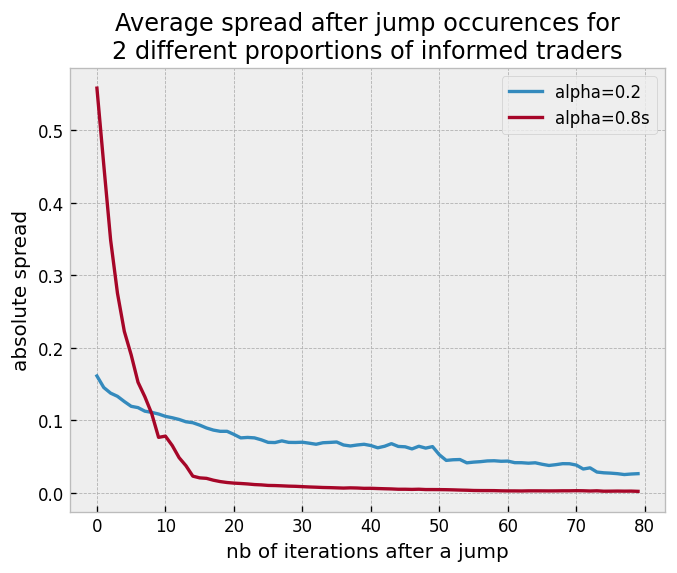

In [621]:
plt.figure(dpi=120)
plt.plot(pd.DataFrame(n_inf).T.mean(1).head(80), label="alpha=0.2")
plt.plot(pd.DataFrame(inform).T.mean(1).head(80), label="alpha=0.8s")
plt.xlabel("nb of iterations after a jump")
plt.ylabel("absolute spread")
plt.legend()
plt.title("Average spread after jump occurences for\n2 different proportions of informed traders")
plt.show()

Observations:

- in the case of less informed traders, the spread rises less when a jump occurs but decreases slowly as less information flows to the MM at each iteration compared to the higher alpha case
- higher alpha case (more informed traders) shows a steeper decline to low spreads
- it is counter intuitive why the spread for high alpha is much higher after the jump but i could make sense of it by thinking that the MM knows there is a lot of information out there (because lots of informed traders) that it does not possess, hence it is *more* unsure of the price compared to the low alpha case (where the MM knows that not many traders have more info than him) (?)
- or perhaps this is a mistake

---

# Profit of MM depending on spread

In [ ]:
spread_profit = GMD_simluation(tmax=300, 
                        sigma_price=0.5, 
                        proba_jump=0.009, 
                        alpha=0.5, 
                        eta=0.5, 
                        sigma_noise=0.05,
                        V0=100, 
                        multiplier=100, 
                        extend_spread=0)
                        
                        

In [ ]:
profit_per_unit_time=[]

for ct in np.linspace(0,0.1,11):

    spread_profit.extend_spread = ct
    spread_profit.run_simulation()
    profit_per_unit_time.append(np.mean(spread_profit.pnl))

100%|██████████| 300/300 [01:43<00:00,  2.91it/s]


Simulation finsihed


100%|██████████| 300/300 [01:41<00:00,  2.94it/s]


Simulation finsihed


100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.88it/s]


Simulation finsihed


100%|██████████| 300/300 [01:43<00:00,  2.89it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.88it/s]


Simulation finsihed


100%|██████████| 300/300 [01:45<00:00,  2.85it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.87it/s]


Simulation finsihed


100%|██████████| 300/300 [01:43<00:00,  2.91it/s]


Simulation finsihed


100%|██████████| 300/300 [01:43<00:00,  2.90it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.87it/s]

Simulation finsihed


In [ ]:
profit_per_unit_time_alpha_07 = [] 
spread_profit.alpha = 0.7


for ct in np.linspace(0,0.1,11):

    spread_profit.extend_spread = ct
    spread_profit.run_simulation()
    profit_per_unit_time_alpha_07.append(np.mean(spread_profit.pnl))

100%|██████████| 300/300 [01:44<00:00,  2.86it/s]


Simulation finsihed


100%|██████████| 300/300 [01:43<00:00,  2.90it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.86it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.87it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.86it/s]


Simulation finsihed


100%|██████████| 300/300 [01:43<00:00,  2.89it/s]


Simulation finsihed


100%|██████████| 300/300 [01:39<00:00,  3.02it/s]


Simulation finsihed


100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


Simulation finsihed


100%|██████████| 300/300 [04:53<00:00,  1.02it/s]  


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.86it/s]


Simulation finsihed


100%|██████████| 300/300 [01:44<00:00,  2.87it/s]

Simulation finsihed


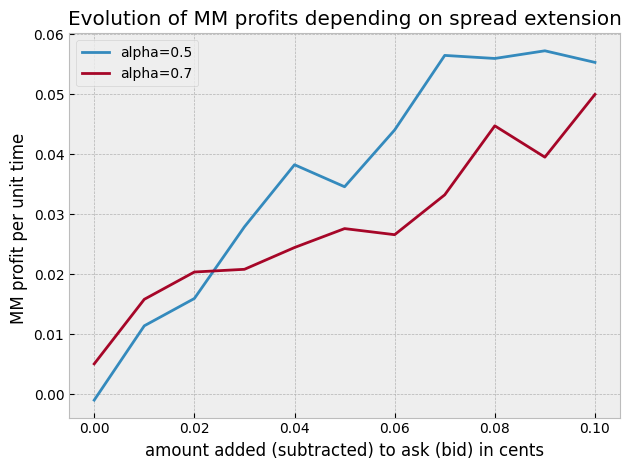

In [ ]:
plt.figure()
plt.plot(np.linspace(0,0.1,11), profit_per_unit_time, label="alpha=0.5")
plt.plot(np.linspace(0,0.1,11), profit_per_unit_time_alpha_07, label="alpha=0.7")
plt.xlabel("amount added (subtracted) to ask (bid) in cents")
plt.ylabel("MM profit per unit time ")
plt.legend()
plt.title("Evolution of MM profits depending on spread extension")
plt.tight_layout()
plt.show()

Observations:

We reproduce the same plot as in Das's paper when we add a few cents to the ask (remove them from the bid).
- It shows that although doing this can increase quite linearly the profit of the MM, The proportion of informed traders decreases it (they have more info and use it)
- 

---

# inventory control

The inventory control function allows to introduce a risk aversion dimension for the MM. 
- when the MM has a positive exposure to the asset, bids and ask are adjusted to favor buying trades (from traders) i.e. traders will probably more want to buy, hence the MM sells and reduces its exposure.
- works the same way for negative exposure but the other way around

-  Inventory control function: -$\gamma I$, where $I$ is the exposure (inventory) of the MM

---

# with real data: GMTUSD (~non liquid)

Adaptations I made:

- first I created another class named GMD_simluation_ext_data
    - it no longer requires a simulated asset price
    - I have an init method taking a path as input to look for the data
- I take n values at the tail of the timeseries (n between 100 and 1000)
- I then rescale the price to be at higher values (100)} so that crossing the zero is less of an issue
- I compute the std of the returns of the asset for that time and also: 
    - since the return distribution is now far from gaussian, I scale up the empirical std to cover a broader range of values. Otherwise the methodology of the paper restricts possible values to a small range compared to the actual price changes observed (example of distribution below)
- I then look at times where the return is greater than the extended sigma and define this as a "jump" to provide the MM with some events similarly as in the model on fake data (this introductes lookahead bias because I assume I know the std of the price returns)

- Also, I chose to stick to gaussian distribution because this is simpler and allow me not to rewrite too much things. But a student-t distribution or power law would more appropriate to model the prior of the asset prices
    
        

In [458]:
example = GMD_simluation_ext_data(tmax = 300,
                            alpha=0.1, 
                            eta=0.5, 
                            sigma_noise=0.1, 
                            data_path="data/GMTUSD.parquet",
                            multiplier=10,
                            nb_sigma_range=5,
                            boost_sigma_price=3)

Boosting std by 3
sigma price= 1.4258722851967227
V0= 100.0


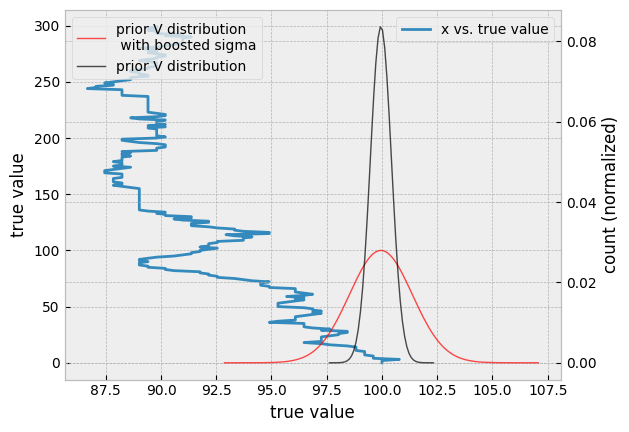

In [459]:
fig, ax = plt.subplots()
dit = Vi_prior(sigma_price=example.sigma_price, 
                    centered_at=example.V0,
                    multiplier=10,
                    nb_sigma_range=5)
dit_normal = Vi_prior(sigma_price=example.sigma_price/3, 
                    centered_at=example.V0,
                    multiplier=10,
                    nb_sigma_range=5)
ax.plot(example.true_value, [i for i in range(example.tmax)], label="x vs. true value")
ax2 = ax.twinx()
ax2.plot(dit.vec_v, dit.prior_v, alpha=0.7, color='r', linewidth=1, label="prior V distribution\n with boosted sigma")
ax2.plot(dit_normal.vec_v, dit_normal.prior_v, alpha=0.7, color='k', linewidth=1, label="prior V distribution")

ax.legend()
ax2.legend()
ax.set_xlabel("true value")
ax.set_ylabel("true value")
ax2.set_ylabel("count (normalized)")
plt.show()


Above: We see above the distribution with boosted sigma covers a broader range of values.
both are centered arount the first true value 

50% noisy informed traders, noise std 1

In [471]:
gmt_simul = GMD_simluation_ext_data(tmax = 300,
                            alpha=0.5, 
                            eta=0.5, 
                            sigma_noise=1, 
                            data_path="data/GMTUSD.parquet",
                            multiplier=10,
                            nb_sigma_range=5,
                            boost_sigma_price=3, 
                            threshold_jump=0.6)


Boosting std by 3
sigma price= 1.4258722851967227
V0= 100.0


In [472]:
gmt_simul.run_simulation()

100%|██████████| 300/300 [00:50<00:00,  5.97it/s]

Simulation finsihed


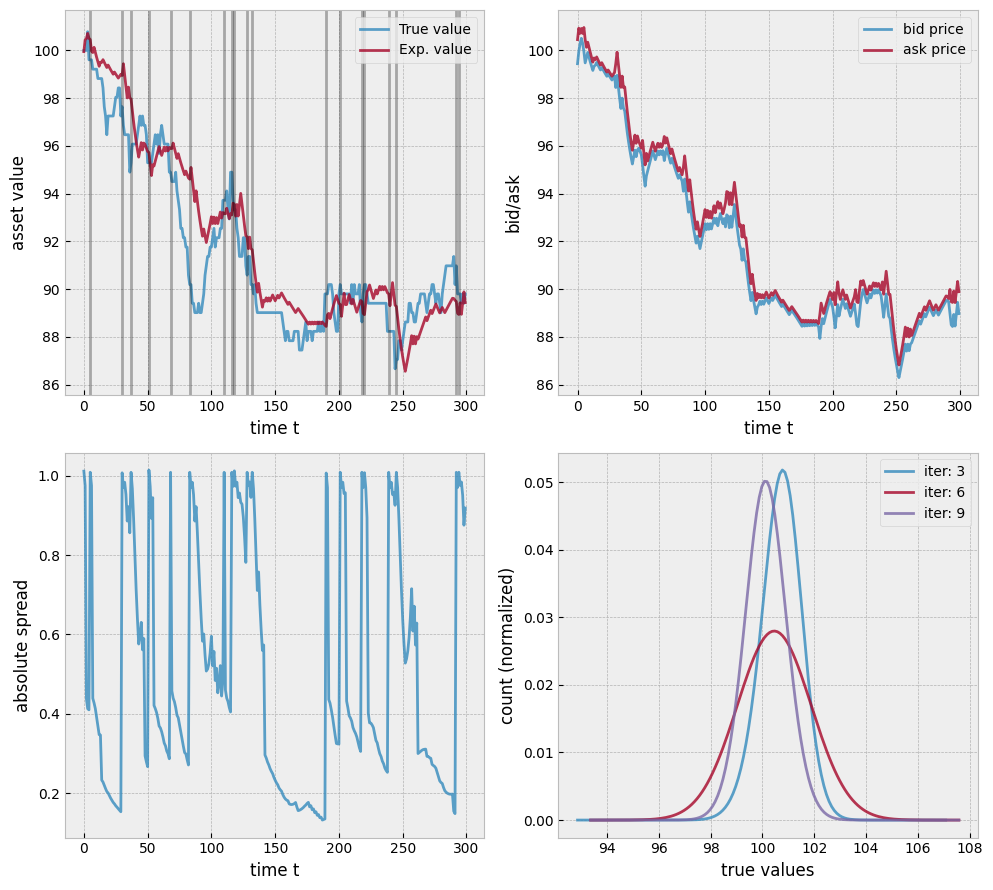

In [484]:
gmt_simul.show_result()

80% noisy informed traders, noise std 1, threshold for jumps is one std

In [479]:
gmt_simul_inf_traders = GMD_simluation_ext_data(tmax = 300,
                            alpha=0.8, 
                            eta=0.5, 
                            sigma_noise=1, 
                            data_path="data/GMTUSD.parquet",
                            multiplier=10,
                            nb_sigma_range=5,
                            boost_sigma_price=3, 
                            threshold_jump=1)


Boosting std by 3
sigma price= 1.4258722851967227
V0= 100.0


In [480]:
gmt_simul_inf_traders.run_simulation()

100%|██████████| 300/300 [00:53<00:00,  5.60it/s]

Simulation finsihed


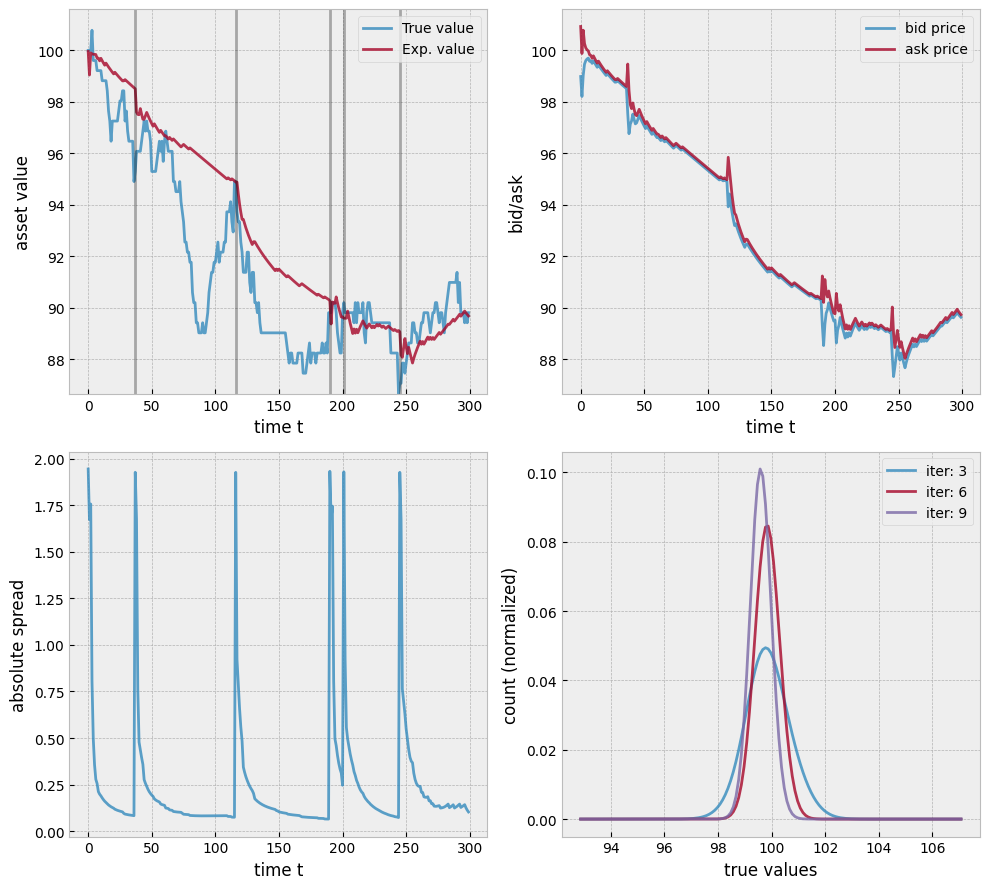

In [483]:
gmt_simul_inf_traders.show_result()

Observations:

- if we put the threshold of jumps to one sigma, the market maker will only receive information that there is a jump in case the return is > one sigma. This is the only chance he has to reset its proba distribution to the expected value. (the jumps occurences are shown in light black color on the upper left plot)
- we see that the expected value decreases but has a hard time tracking the true value. 

The jump info seems to greatly benefit the MM 



Now with less informed traders (alpha=0.3):

In [492]:
gmt_simul_non_inf_traders = GMD_simluation_ext_data(tmax = 300,
                            alpha=0.2, 
                            eta=0.5, 
                            sigma_noise=1, 
                            data_path="data/GMTUSD.parquet",
                            multiplier=10,
                            nb_sigma_range=5,
                            boost_sigma_price=3, 
                            threshold_jump=1)

Boosting std by 3
sigma price= 1.4258722851967227
V0= 100.0


In [493]:
gmt_simul_non_inf_traders.run_simulation()

100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


Simulation finsihed


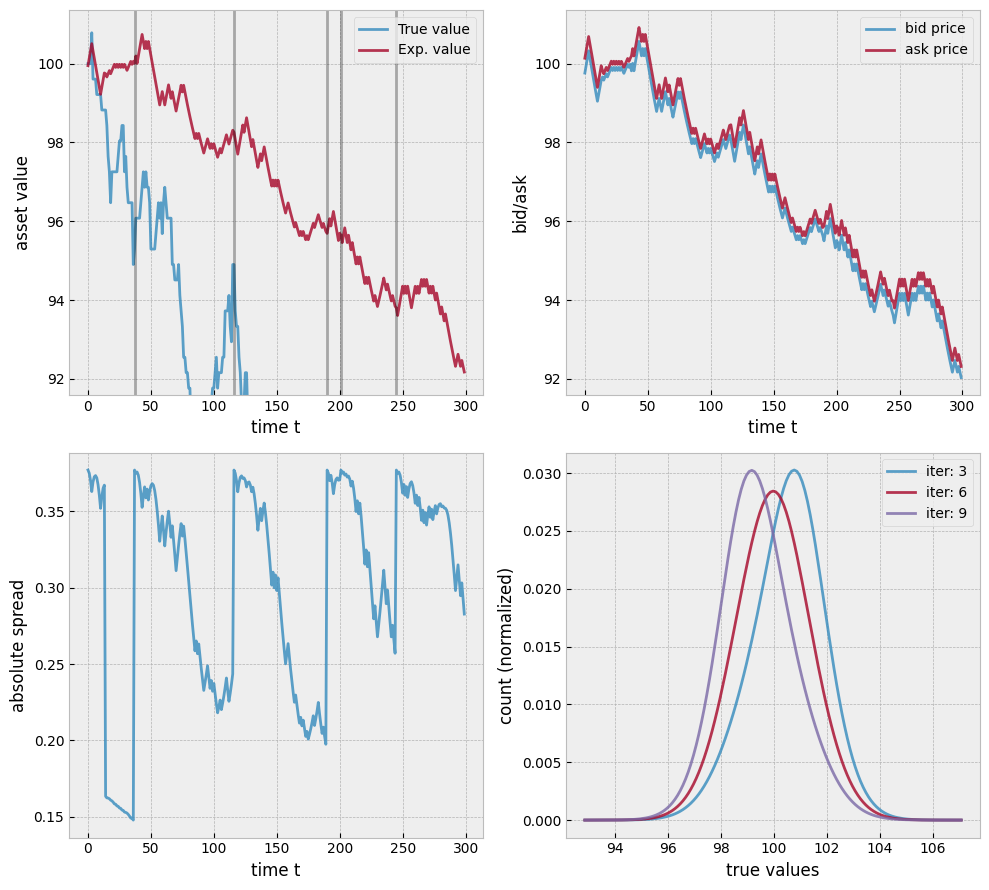

In [494]:
gmt_simul_non_inf_traders.show_result()

Observations:

- with less informed traders, the expected value varies less, and decreases gently, not efficiently tracking the true value

- Also, the jumps induce a spread increase which lasts a " long " time, generellay the spread has a hard time decreasing to very low values here
 

If we put now more informed traders are more jumps info (lower the threshold)

In [495]:
gmt_simul_inf_traders_small_threshold = GMD_simluation_ext_data(tmax = 300,
                            alpha=0.8, 
                            eta=0.5, 
                            sigma_noise=1, 
                            data_path="data/GMTUSD.parquet",
                            multiplier=10,
                            nb_sigma_range=5,
                            boost_sigma_price=3, 
                            threshold_jump=0.6)

Boosting std by 3
sigma price= 1.4258722851967227
V0= 100.0


In [496]:
gmt_simul_inf_traders_small_threshold.run_simulation()

100%|██████████| 300/300 [00:49<00:00,  6.05it/s]

Simulation finsihed


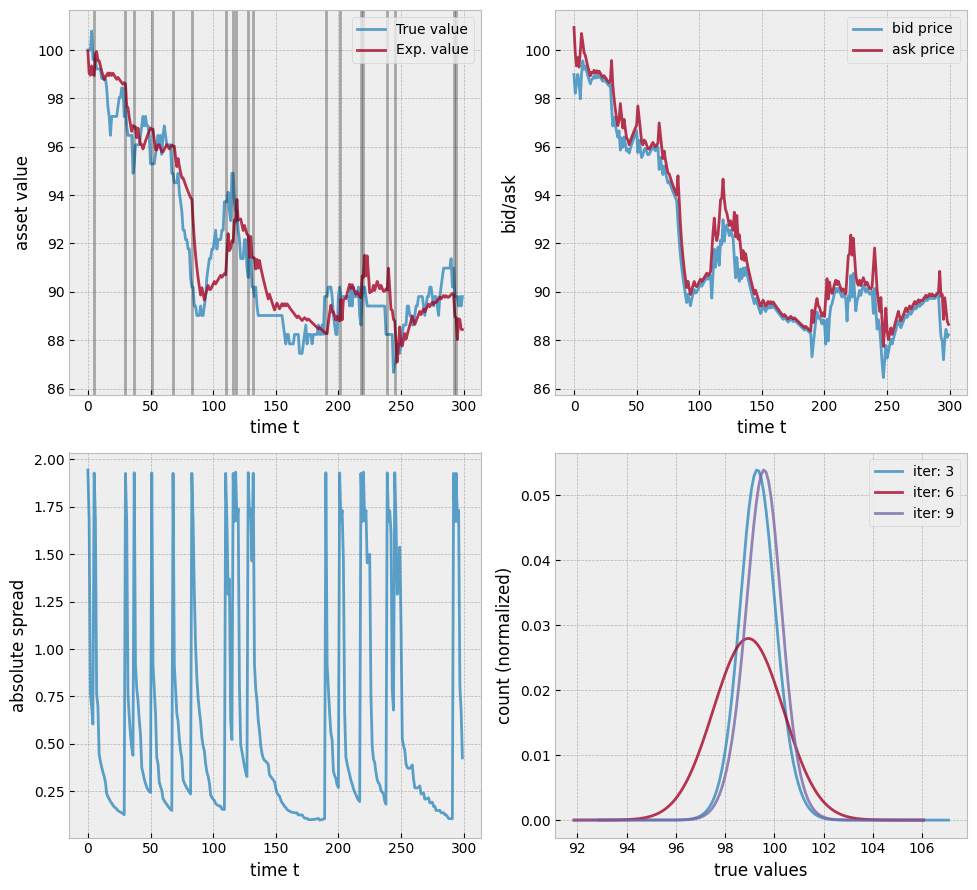

In [497]:
gmt_simul_inf_traders_small_threshold.show_result()

Observations:

- we now have the expected value that is tracked more efficiently
-  the spread is higher in general due to frequent information coming in
- the spread also decreases quicker than before


---

# with real data: ETHUSD (liquid)

In [598]:
eth_simul = GMD_simluation_ext_data(tmax = 1000,
                            alpha=0.8, 
                            eta=0.5, 
                            sigma_noise=0.1, 
                            data_path="data/ETHUSD.parquet",
                            multiplier=20,
                            nb_sigma_range=30,
                            boost_sigma_price=20,
                            threshold_jump=0.18)

Boosting std by 20
sigma price= 0.12682108640585593
V0= 100.0


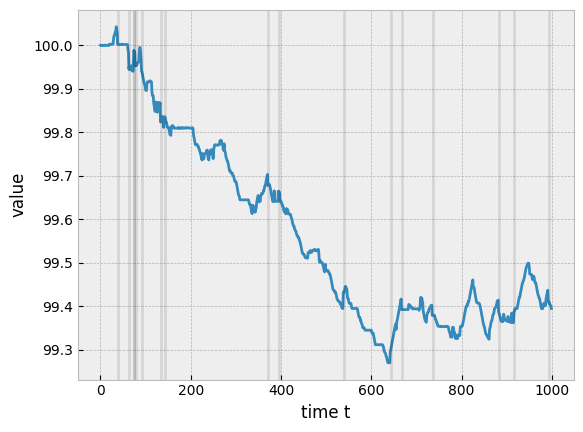

In [599]:
eth_simul.show_true_value(with_jumps=True)

In [600]:
eth_simul.run_simulation()

vec_v from 96.19536740782432 to 103.79536740782432 with len 153


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]

Simulation finsihed


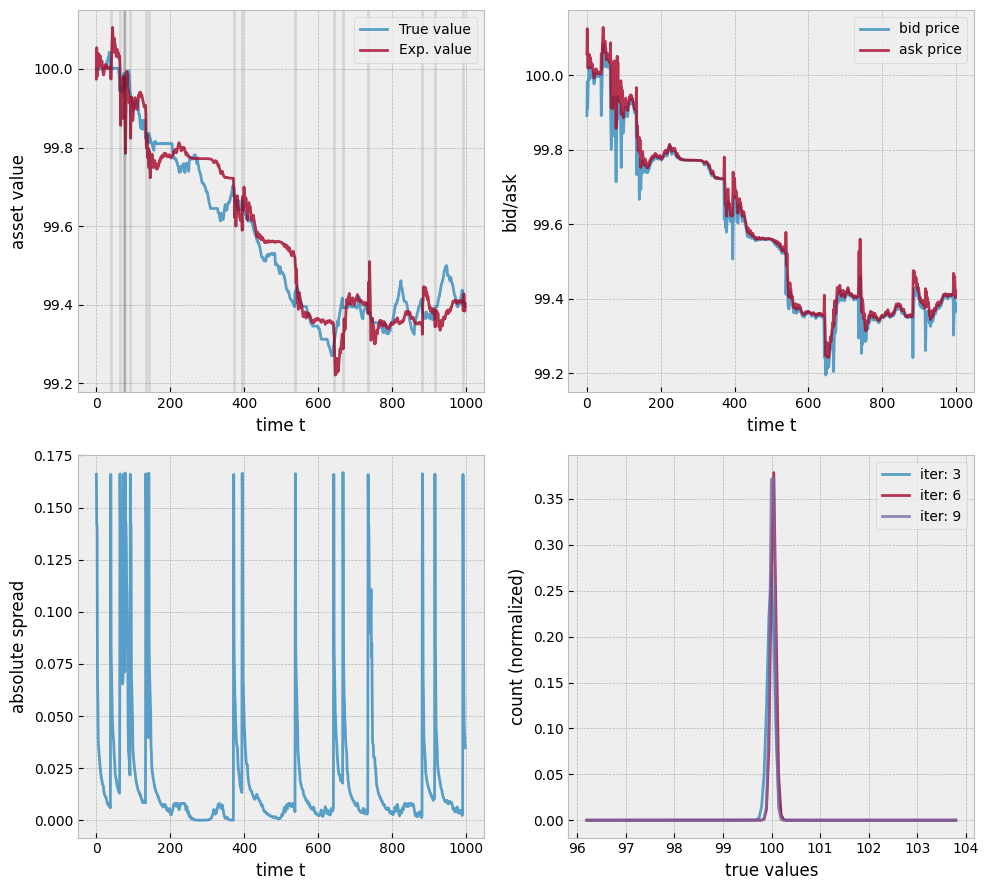

In [601]:
eth_simul.show_result(same_y_axis_above=False)

Observations:

- The parameters needed to be adjusted (freq of jumps, multiplier for std and the )
- with 80% informed traders, we can keep track of the true value, although with a lag as above.

With less informed traders

In [602]:
eth_simul_less_inf = GMD_simluation_ext_data(tmax = 1000,
                            alpha=0.2, 
                            eta=0.5, 
                            sigma_noise=0.1, 
                            data_path="data/ETHUSD.parquet",
                            multiplier=20,
                            nb_sigma_range=30,
                            boost_sigma_price=20,
                            threshold_jump=0.18)

Boosting std by 20
sigma price= 0.12682108640585593
V0= 100.0


In [603]:
eth_simul_less_inf.run_simulation()

vec_v from 96.19536740782432 to 103.79536740782432 with len 153


100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]

Simulation finsihed


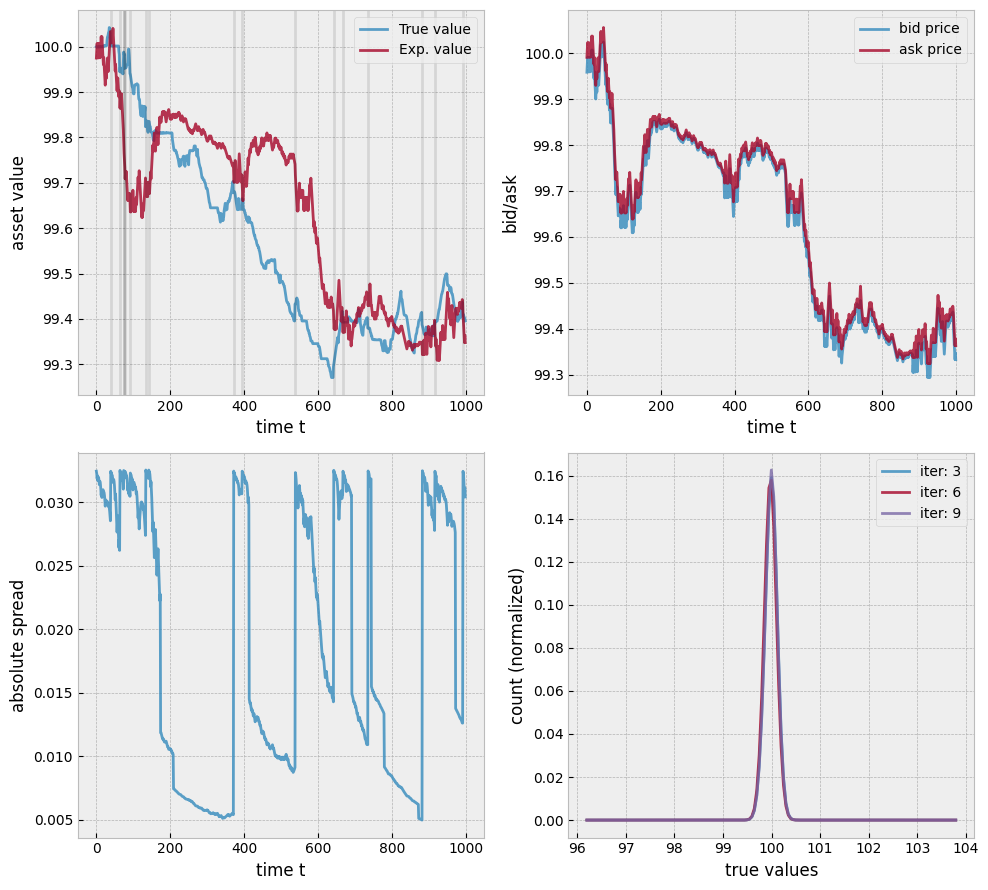

In [604]:
eth_simul_less_inf.show_result(same_y_axis_above=False)

the spread seams to be lower with less informed traders, which is not really expected, 
But it might me due, in my simulation, that the truve value is not really well tracked by the model
- ths spread jumps up when jumps occur but the spread remains relatively low

---

TODOS / NEXTSTEPS:


- adjust the model on real data and obtain more meaninful results (less noisy and do rigorous analysis once it is set up)
- Inventory control from Das paper is implemented but not yet studied 
- need to refine prior distributions for real data, as price returns are not gaussian but heavy tailed and volatility is high
- need then to, in accordance with probability distributions used, rederive (if possible) the model equations and follow with the implementation to potentially obtain more results
- need also to study the lookahead bias in the case of real data and how we could get aorund it
    - for instance with a model agnostic of jumps (as Das paper breifly talks about)
    - having a rolling estimate of the std that would partially solve the problem, the MM still benefits from jump occurences information

